In [1]:
import numpy as np
import MDAnalysis as mda
import importlib
import XS_calc
from XS_calc import *

import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline

In [2]:
importlib.reload(XS_calc) # This reloads XS_calc
from XS_calc import *     # This updates the functions in XS_calc

In [73]:
importlib.reload(XS_calc) # This reloads XS_calc
from XS_calc import *     # This updates the functions in XS_calc
U = mda.Universe('data/Ala10.pdb')
traj = Trajectory(U, selection='protein', match_FoXS=False)
frame = traj.Frames[0]
# print(frame.mol.vdW)
env = Environment(c2=2)
mea = Measurement(q = np.linspace(0.00, 0.5, num=101))
frame.SASA_calc(env, force_recalc=True)

FF_q = FF_calc(frame, env, mea)
# XS = frame_XS_calc(frame, env, mea)
# an i by j matrix of distances between all atoms
# d_ij = np.sqrt(np.sum((frame.xyz[None,:,:]-frame.xyz[:,None,:])**2, axis=2))

# XS = np.zeros(np.shape(mea.q))
# for i in np.arange(frame.mol.n_atoms):
#     for j in np.arange(i+1, frame.mol.n_atoms):
#         qd = mea.q * d_ij[i,j]
#         XS += 2 * FF_q[i] * FF_q[j] * np.sinc(qd / np.pi)
#     XS += FF_q[i] ** 2

The protein has 104 atoms


In [4]:
XS

array([8176961.42066028, 8162174.47260291, 8117965.06670414,
       8044785.08425881, 7943379.60070685, 7814774.97467962,
       7660262.52626686, 7481378.14722889, 7279878.26869971,
       7057712.6839752 , 6816994.78355698, 6559969.80535128,
       6288981.73382368, 6006439.49741949, 5714783.11352526,
       5416450.41502436, 5113844.96271753, 4809305.70470948,
       4505078.88869986, 4203292.66769534, 3905934.76600799,
       3614833.49259113, 3331642.30513342, 3057828.04311763,
       2794662.86355269, 2543219.83146757, 2304372.04053038,
       2078795.06911022, 1866972.51530334, 1669204.30210832,
       1485617.40201875, 1316178.59935946, 1160708.88899811,
       1018899.1015105 ,  890326.34707422,  774470.88261103,
        670733.02804755,  578449.78685409,  496910.86192663,
        425373.7989474 ,  363078.03409025,  309257.66979902,
        263152.84987281,  224019.65182919,  191138.45919593,
        163820.81786813,  141414.81800335,  123309.0753632 ,
        108935.4129989 ,

In [202]:

importlib.reload(XS_calc) # This reloads XS_calc
from XS_calc import *     # This updates the functions in XS_calc

def frame_XS_calc_exp(frame, env, mea, num_q_pt = 200, ignoreSASA=False, timing=False):
    q_sphere = raster_unit_sphere(num_q_pt)

    t0 = time.time()
    if not ignoreSASA:
        # Get the SASA calculated if not done
        frame.SASA_calc(env)
    t1 = time.time()
    # Calculate adjusted form factors as a table.
    FF_q = FF_calc(frame, env, mea)
    t2 = time.time()
    # Calculate scattering signal XS - currently this is quite slow. There has to be a way to make it faster
    XS = np.zeros(np.shape(mea.q))

    for idx, q in enumerate(mea.q):
        A = np.sum(FF_q[:,idx] * np.exp(-(1j) * q * np.dot(q_sphere, frame.xyz.T)), axis=1)
        XS[idx] = np.mean(np.abs(A)**2)
    t3 = time.time()
    if timing:
        time_ms(t1, t0, 'SASA')
        time_ms(t2, t1, '  FF')
        time_ms(t3, t2, 'Xray')
    return XS

In [296]:
def frame_XS_calc_fast(frame, env, mea, ignoreSASA=False, timing=False): # Calculate the X-ray scattering of a frame
    t0 = time.time()
    if not ignoreSASA:
        # Get the SASA calculated if not done
        frame.SASA_calc(env)
    t1 = time.time()
    # Calculate adjusted form factors as a table.
    FF_q = FF_calc(frame, env, mea)
    t2 = time.time()
    # an i by j matrix of distances between all atoms
    d_ij = np.sqrt(np.sum((frame.xyz[None,:,:]-frame.xyz[:,None,:])**2, axis=2))
    d_ij += np.eye(len(d_ij)) * 1e-15
    t3 = time.time()

    # Calculate scattering signal XS - currently this is quite slow. There has to be a way to make it faster
    XS = np.zeros(np.shape(mea.q))
#     print((FF_q[:,None,:] * FF_q[:,:,None]).shape)

# This huge one-liner is slow
#     XS = np.sum((FF_q[:,None,:] * FF_q[:,:,None]) * np.sinc(mea.q[:, None, None] * d_ij[None,:,:] / np.pi), axis=(-1, -2))

# This q by q version is pretty good
    for idx, q in enumerate(mea.q):
        if q == 0.0:
            XS[idx] = np.sum((FF_q[:,idx][None,:] * FF_q[:, idx][:,None]))
#         XS[idx] = np.sum((FF_q[:,idx][None,:] * FF_q[:, idx][:,None]) * np.sinc(d_ij * q / np.pi))
        else:
            XS[idx] = np.sum((FF_q[:,idx][None,:] * FF_q[:, idx][:,None]) * np.sin(d_ij * q) / (d_ij * q))
    t4 = time.time()
    
# This element by element version is really slow
#     for i in np.arange(frame.mol.n_atoms):
#         for j in np.arange(i+1, frame.mol.n_atoms):
#             qd = mea.q * d_ij[i,j]
#             XS += 2 * FF_q[i] * FF_q[j] * np.sinc(qd / np.pi)
#         XS += FF_q[i] ** 2

    if timing:
        time_ms(t1, t0, 'SASA')
        time_ms(t2, t1, '  FF')
        time_ms(t3, t2, 'dist')
        time_ms(t4, t3, 'Xray')
    return XS

In [339]:
U = mda.Universe('data/Ala10.pdb')
traj = Trajectory(U, selection='protein', match_FoXS=False)
frame = traj.Frames[0]
env = Environment(c2=2)
mea = Measurement(q = np.linspace(0.00, 0.5, num=101))
# frame.SASA_calc(env, force_recalc=True)

The protein has 104 atoms


In [340]:
import time
def time_ms(t1, t0, message=None):
    if message is not None and len(message) > 0:
        print(f'{message}: {(t1-t0)*1000:.2f} ms')
    else:
        print(f'{(t1-t0)*1000:.2f} ms')

In [341]:
t0 = time.time()
XS = frame_XS_calc_fast(frame, env, mea, timing=True)
t1 = time.time()
time_ms(t1, t0, 'overall')

SASA: 26.98 ms
  FF: 4.87 ms
dist: 0.33 ms
Xray: 6.88 ms
overall: 39.39 ms


In [342]:
XS.shape

(101,)

In [343]:
t0 = time.time()
XS2 = frame_XS_calc_exp(frame, env, mea, num_q_pt=200, timing=True) 
t1 = time.time()
time_ms(t1, t0, '')

SASA: 0.00 ms
  FF: 5.62 ms
Xray: 49.05 ms
56.48 ms


In [344]:
# t0 = time.time()
# XS3 = frame_XS_calc(frame, env, mea)
# t1 = time.time()
# time_ms(t1, t0)

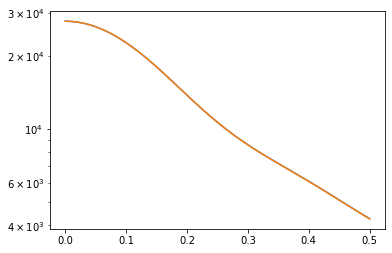

In [345]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(mea.q, XS)
plt.plot(mea.q, XS2)
# plt.plot(mea.q, XS3)
plt.yscale('log')

In [346]:
XS2_diag = []
XS2_error = []
q_range = list(range(10, 210, 2))
for i in q_range:
    print(i, end=' ')
    XS2_this = frame_XS_calc_exp(frame, env, mea, num_q_pt=i, timing=False)
#     print(XS2_this)
    XS2_diag.append(XS2_this)
    XS2_error.append(np.sqrt(np.sum(((XS2_this - XS)/XS)**2)))

10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 100 102 104 106 108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142 144 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178 180 182 184 186 188 190 192 194 196 198 200 202 204 206 208 

In [347]:
XS2_error

[1.8985493257259844,
 1.9105360740230288,
 1.215609294710416,
 1.774209564141087,
 1.053770633395324,
 0.46680339905355017,
 0.5965364195719444,
 0.44809622211721795,
 0.6331452483206464,
 0.4723888658661656,
 0.5132897306156584,
 0.07997660468696348,
 0.08662528963272174,
 0.06303386423705275,
 0.3482460190495496,
 0.2418305374597428,
 0.05218835818634329,
 0.12821505366316124,
 0.04866314963048782,
 0.12822215544929186,
 0.07809346891680576,
 0.0679609918437056,
 0.08633896373403492,
 0.08023653152135511,
 0.0297547035880444,
 0.057180566736566074,
 0.004869327094220462,
 0.04987356449177967,
 0.034225078173369214,
 0.016805844445233295,
 0.053224000379773574,
 0.054529889684907996,
 0.03257662386786103,
 0.013994378682708197,
 0.026867144511560102,
 0.0028062915959851816,
 0.00657886409814294,
 0.018270736223125465,
 0.01926302313647132,
 0.012577892438113442,
 0.03311277929821792,
 0.0337734188716288,
 0.024957527475376287,
 0.014195874177311028,
 0.014121256977666679,
 0.014458045

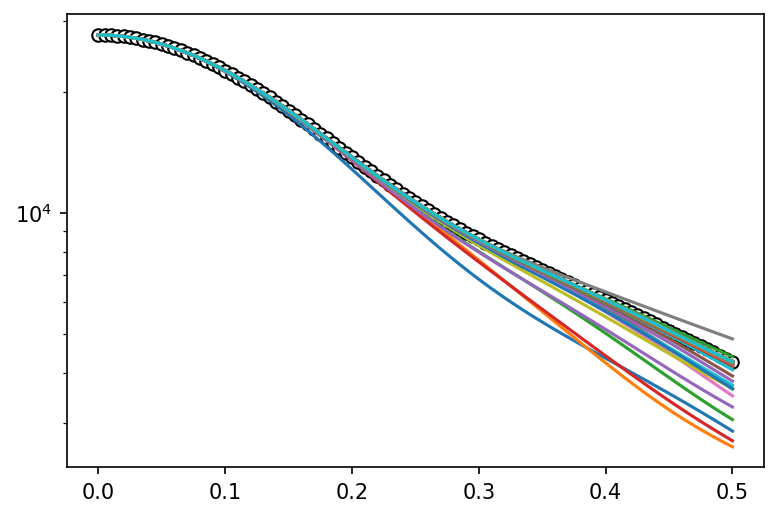

In [348]:
plt.figure(dpi=150)
plt.plot(mea.q, XS, '-ok', markerfacecolor='w')
for idx, i in enumerate(q_range):
    plt.plot(mea.q, XS2_diag[idx])
plt.yscale('log')
plt.show()

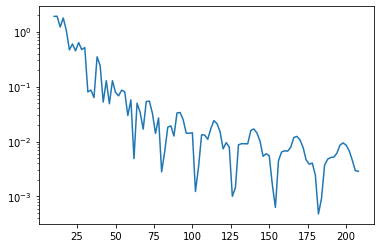

In [349]:
plt.figure()
plt.plot(q_range, XS2_error)
plt.yscale('log')
plt.show()